https://www.nltk.org/api/nltk.tokenize.treebank.html

In [1]:
# from gensim.models import KeyedVectors

# # Replace 'path/to/word2vec/model.bin' with the path to your pretrained Word2Vec model
# model_path = 'path/to/word2vec/model.bin'
# word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# # Access the vector for a specific word
# vector_for_word = word2vec_model['example']


In [1]:
import re
import pandas as pd

import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import HighlightText, ax_text, fig_text

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


import nltk
from nltk.tokenize import TreebankWordTokenizer

from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

# Data preparation

## Tokenize sentence and aspect BIO encoding class

In [2]:
class SentenceToken:
  '''
    SentenceToken

  '''
  def __init__(self, sentence, aspect_type=None, aspects=None, sentence_id=None):
    
    if sentence_id is not None:
      print(sentence_id)

    self.sentence_id = sentence_id
    self.sentence = sentence.replace(u"\u00A0", " ")
                            
    self.aspect_bio_tags = None
    self.unified_aspect_bio_tags = None
    self.token_span = None
    self.space_pre_token = None

    # Tokenize sentence
    self.__tokenize_sentence(self.sentence)

    if aspect_type == 'dict':
      self.set_aspect_tagging_from_dict(aspects)
    elif aspect_type == 'bio':
      self.set_aspect_bio_tags(aspects)
    elif aspect_type == 'unified bio':
      self.set_aspect_unified_bio_tags(aspects)
  
  def __tokenize_sentence(self, sentence):
    # self.sentence = sentence
    
    token_span = list(TreebankWordTokenizer().span_tokenize(sentence))

    new_token_span = []
    
    for k in token_span:
      token_start = k[0]
      token_end = k[1]

      token = sentence[token_start:token_end]
      sub_tokens = re.split(r'([^\w,\d])', token)
      
      sub_token_start = token_start
      for sub_token in sub_tokens:
        if len(sub_token) != 0:
          sub_token_end = sub_token_start + len(sub_token)
          new_token_span.append((sub_token_start, sub_token_end))
          sub_token_start = sub_token_end
    
    self.token_span = new_token_span
    self.space_pre_token = [True if sentence[k[0]-1:k[0]] == ' ' else False for i,k in enumerate(new_token_span)]


  def set_aspect_tagging_from_dict(self, aspects):
    polarity_map = {'positive':'POS'
              ,'negative': 'NEG'
              ,'conflict': 'CON'
              ,'neutral': 'NEU'}
    
    bio_tags = ['O'] * len(self.token_span)
    unified_bio_tags = bio_tags

    for x in aspects:
      if x['term'] != '':
        aspect_from = int(x['from'])
        aspect_to = int(x['to'])
        polarity = '-' + polarity_map[x['polarity']]
        aspect_token_ids =  [i for i, v in enumerate(self.token_span) if (v[0] >= aspect_from) & (v[1] <= aspect_to)]
        aspect_from_index = min(aspect_token_ids)
        aspect_to_index = max(aspect_token_ids)
        aspect_length = aspect_to_index - aspect_from_index
        bio_tags = bio_tags[:aspect_from_index] + ['B'] + ['I'] * (aspect_length) + bio_tags[aspect_to_index+1:]
        unified_bio_tags = unified_bio_tags[:aspect_from_index] + ['B' + polarity] + ['I'+ polarity] * (aspect_length) + unified_bio_tags[aspect_to_index+1:]
    
    self.set_aspect_bio_tags(bio_tags)
    self.set_aspect_unified_bio_tags(unified_bio_tags)

  def rebuild_sentence_from_token(self):
    return ''.join([(' ' if self.space_pre_token[i] else '') + self.sentence[k[0]:k[1]] for i, k in enumerate(self.token_span)])
  
  def get_sentence_token_with_aspect_bio_tag(self, unified_bio_tag=False):
    if (unified_bio_tag == False) & (self.aspect_bio_tags is None):
      raise Exception('No BIO tags provided. Use "SentenceToken.set_aspect_bio_tags()" method to add bio_tags')
    elif (unified_bio_tag == True) & (self.aspect_unified_bio_tags is None):
      raise Exception('No Unified BIO tags provided. Use "SentenceToken.set_aspect_unified_bio_tags()" method to add unified_bio_tags')
    else:
      return [(self.sentence[k[0]:k[1]], self.aspect_unified_bio_tags[i] if unified_bio_tag else self.aspect_bio_tags[i]) for i, k in enumerate(self.token_span)]

  def set_aspect_bio_tags(self, aspect_bio_tags):
    self.aspect_bio_tags = aspect_bio_tags
    self.aspect_unified_bio_tags = aspect_bio_tags

  def set_aspect_unified_bio_tags(self, aspect_unified_bio_tags):
    self.aspect_unified_bio_tags = aspect_unified_bio_tags
    self.aspect_bio_tags = [k[0:1] for k in aspect_unified_bio_tags]

  def check_rebuild_sentence_from_token(self):
    return re.sub(r'\s+', ' ',self.sentence.strip()) == self.rebuild_sentence_from_token().strip()
  
  def get_tokens(self):
    return [self.sentence[k[0]:k[1]] for k in self.token_span]

  def check_rebuild_aspect_terms(self, aspect_dict):
    aspect_dict = sorted(aspect_dict, key=lambda d: int(d['from']))
    aspect_input = ', '.join([k['term'] for k in aspect_dict])
    aspect_computed = ''.join([(', ' if k == 'B' else '') + self.sentence[self.token_span[i][0]:self.token_span[i][1]] for i,k in enumerate(self.aspect_bio_tags) if k in ['B','I'] ])[2:]
    
    return (aspect_input == aspect_computed, aspect_input, aspect_computed)

  def __str__(self):
    return self.rebuild_sentence_from_token()


In [3]:
df_train = pd.read_json('data/laptop/train.json')
# df_train.set_index('id', inplace=True).reset_index()
print('df_train shape: ', df_train.shape)

df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
# df_val.set_index('id', inplace=True).reset_index()
print('df_val shape: ', df_val.shape)

# First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
df_train.drop_duplicates(subset='text', inplace=True)

# We have removed 12 duplicated records in our training dataset
print(df_train.shape)

df_train shape:  (3048, 3)
df_val shape:  (800, 3)
(3036, 3)


In [4]:
df_train['sentence_token'] = df_train.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
df_train['sentence_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
df_train['aspect_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)

df_val['sentence_token'] = df_val.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
df_val['sentence_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
df_val['aspect_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)

In [5]:
print('# of df_train records having tokenizing issues: ', len(df_train[df_train['sentence_check']==False]))
print('# of df_train records having aspect bio tagging issues: ', len(df_train[df_train['aspect_check']==False]))
print('# of df_val records having tokenizing issues: ', len(df_val[df_val['sentence_check']==False]))
print('# of df_val records having  aspect bio tagging issues: ', len(df_val[df_val['aspect_check']==False]))

# of df_train records having tokenizing issues:  0
# of df_train records having aspect bio tagging issues:  0
# of df_val records having tokenizing issues:  0
# of df_val records having  aspect bio tagging issues:  0


# EDA

## Sentence length

In [6]:
df_train['sentence_length'] = df_train.apply(lambda x: len(x['sentence_token'].get_tokens()), axis=1)

In [7]:
fig = px.ecdf(df_train['sentence_length'], marginal="histogram", title='90% reviews have <= 30 words')
fig. update_layout(showlegend=False,
                   xaxis_title="# of words in reviews",
                   yaxis_title="Review counts")
fig.show()

# CRF with FastText embeddings

In [52]:
def sentence_embeddings_to_dict (sentence_embeddings, window = 5):
  sentence_features = []
  for i in range(0, len(sentence_embeddings)):
    word_features = {}
    word_embeddings = sentence_embeddings[i]
    word_features.update(word_embeddings_to_dict(word_embeddings,f'word'))
    
    if i > 0:
      for k in range(1, min(window, i)+1):
          # prev_word = tokens[i - k]
          prev_word_embeddings = sentence_embeddings[i-k]
          # print('prev_word: ', prev_word)
          word_features.update(word_embeddings_to_dict(prev_word_embeddings,f'-{k}:word'))
    else:
        word_features['BOS'] = True  # Beginning of sentence

    if i < len(sentence_embeddings) - 1:
      for k in range(1, min(window, len(sentence_embeddings) - i - 1)+1):
        # next_word = tokens[i + k]
        next_word_embeddings = sentence_embeddings[i+k]
        # print('next_word: ', next_word)
        # print(next_word_embeddings)
        word_features.update(word_embeddings_to_dict(next_word_embeddings,f'+{k}:word'))
    else:
        word_features['EOS'] = True  # End of sentence

    sentence_features.append(word_features)
    
  return sentence_features

def word_embeddings_to_dict(embeddings, feature_prefix='word'):
  
  
  word_features = {}
  for iv,value in enumerate(embeddings):
    word_features[f'{feature_prefix}:v_{iv}'] = value
  
  return word_features

In [88]:
fasttext_model = fasttext.load_model('cc.en.300.bin')
X_train_word_embeddings = [[fasttext_model.get_word_vector(token) for token in sentence_token.get_tokens()] for sentence_token in df_train['sentence_token']]

In [93]:
X_train_dict = [sentence_embeddings_to_dict(sentence_embeddings) for sentence_embeddings in X_train_word_embeddings]
X_train_dict

In [ ]:
y_train = df_train['sentence_token'].apply(lambda x: x.aspect_unified_bio_tags)

In [ ]:
X_train_crf, X_test_crf, y_train, y_test = train_test_split(X_train_dict, y_train, test_size=0.2, random_state=42)

In [72]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs',
                max_iterations=100,
                c1=0.5,
                c2=0.05)

# There is this error existing with this library: 'CRF' object has no attribute 'keep_tempfiles'
# which has not been resolved and we can bypass it using this trick.
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

Accuracy: 0.9805292419289413
Classification Report:
              precision    recall  f1-score   support

       B-CON       1.00      0.22      0.36        36
       B-NEG       0.87      0.71      0.78       651
       B-NEU       0.93      0.60      0.73       348
       B-POS       0.86      0.76      0.80       789
       I-CON       1.00      0.38      0.55        16
       I-NEG       0.93      0.88      0.90       365
       I-NEU       0.93      0.84      0.88       232
       I-POS       0.86      0.86      0.86       311
           O       0.99      1.00      0.99     39161

    accuracy                           0.98     41909
   macro avg       0.93      0.69      0.76     41909
weighted avg       0.98      0.98      0.98     41909



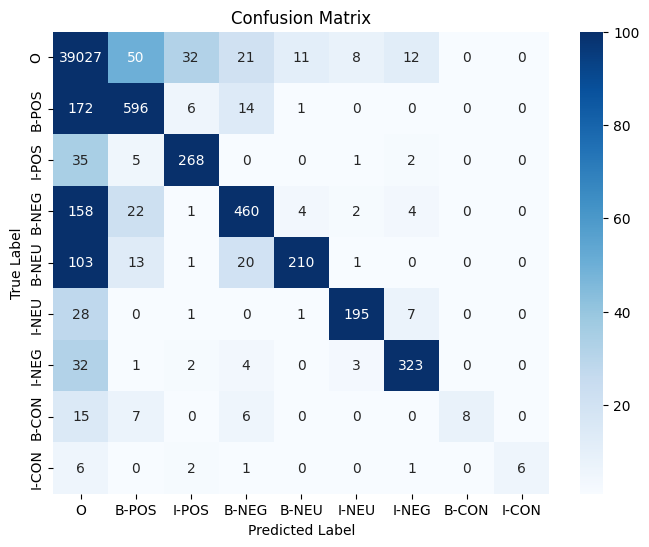

In [73]:
y_train_crf_pred = crf_model.predict(X_train_crf)

y_train_flat = [tag for sentence in y_train for tag in sentence]
y_train_crf_pred_flat = [tag for sentence in y_train_crf_pred for tag in sentence]


# Evaluate the model
accuracy = accuracy_score(y_train_flat, y_train_crf_pred_flat)
classification_rep = classification_report(y_train_flat, y_train_crf_pred_flat)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train_flat, y_train_crf_pred_flat, labels=crf_model.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crf_model.classes_, yticklabels=crf_model.classes_, vmax=100, vmin=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.9305243445692883
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00         9
       B-NEG       0.44      0.29      0.35       215
       B-NEU       0.39      0.23      0.29       115
       B-POS       0.51      0.44      0.47       199
       I-CON       0.00      0.00      0.00         9
       I-NEG       0.31      0.33      0.32       108
       I-NEU       0.36      0.36      0.36        98
       I-POS       0.41      0.28      0.33       105
           O       0.97      0.98      0.97      9822

    accuracy                           0.93     10680
   macro avg       0.38      0.32      0.34     10680
weighted avg       0.92      0.93      0.92     10680



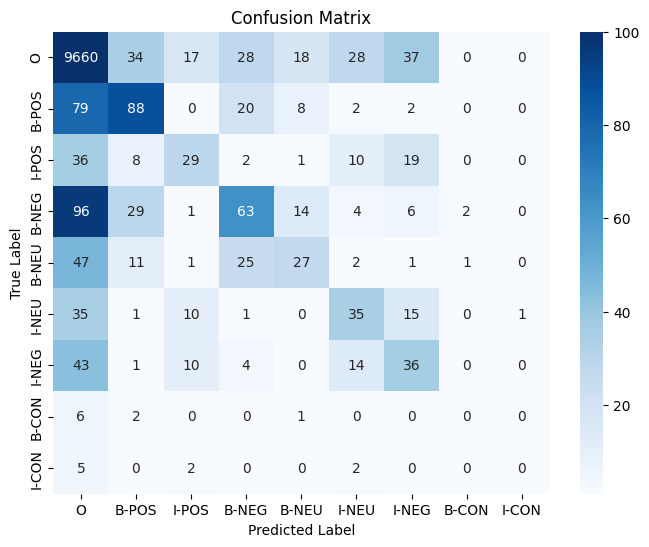

In [74]:
y_test_crf_pred = crf_model.predict(X_test_crf)

y_test_flat = [tag for sentence in y_test for tag in sentence]
y_test_crf_pred_flat = [tag for sentence in y_test_crf_pred for tag in sentence]


# Evaluate the model
accuracy = accuracy_score(y_test_flat, y_test_crf_pred_flat)
classification_rep = classification_report(y_test_flat, y_test_crf_pred_flat)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_test_crf_pred_flat, labels=crf_model.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crf_model.classes_, yticklabels=crf_model.classes_, vmax=100, vmin=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [85]:
missing_words = set(token  for sentence_token in df_train['sentence_token'] for token in sentence_token.get_tokens() if token not in fasttext_model.words)
len(missing_words)

90

# RNN

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

X_train_words = [sentence_token.get_tokens() for sentence_token in df_train['sentence_token']]

# Create a tokenizer
tokenizer = Tokenizer(char_level=False, lower=True)
# Fit on your list of words
tokenizer.fit_on_texts(X_train_words)

word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Vocabulary size: {len(all_words)}")

dataset = tokenizer.texts_to_sequences(X_train_words)

print(dataset[0])


Vocabulary size: 4095
[3, 286, 5, 52, 643, 6, 2149, 420, 2, 794, 17, 33, 89, 12, 2, 81, 74, 100, 1]


<Axes: title={'center': 'Word count'}, xlabel='word'>

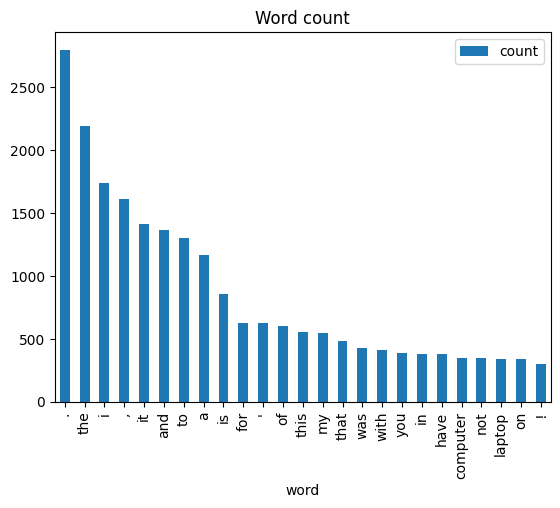

In [26]:
word_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["word", "count"])
word_frequency = word_frequency.sort_values("count", ascending=False)[:25]
word_frequency.set_index("word").plot(kind="bar", rot=90, title="Word count")

In [27]:
y_train_words = df_train['sentence_token'].apply(lambda x: x.aspect_unified_bio_tags)

Tags size: 9


<Axes: title={'center': 'Word count'}, xlabel='word'>

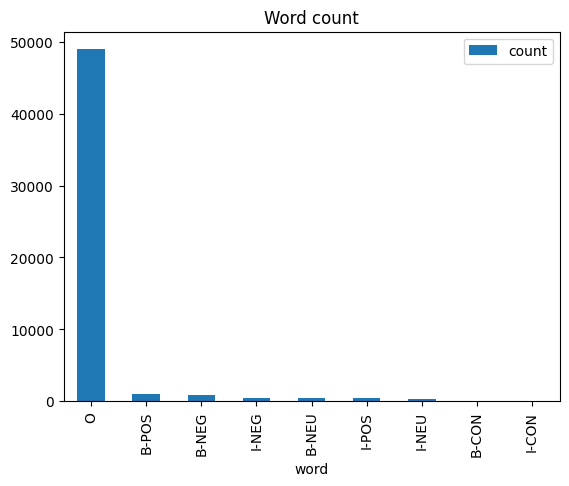

In [28]:

# Create a tokenizer
y_tokenizer = Tokenizer(char_level=False, lower=False)
# Fit on your list of words
y_tokenizer.fit_on_texts(y_train_words)


tag_to_number = y_tokenizer.word_index
number_to_tag = y_tokenizer.index_word

all_tags = list(tag_to_number.keys())

print(f"Tags size: {len(all_tags)}")

y_train = y_tokenizer.texts_to_sequences(y_train_words)


word_frequency = pd.DataFrame(data=y_tokenizer.word_counts.items(), columns=["word", "count"])
word_frequency = word_frequency.sort_values("count", ascending=False)[:25]
word_frequency.set_index("word").plot(kind="bar", rot=90, title="Word count")

In [38]:
##### THIS NEEDS REVISE LOGIC - CURRENTLY IS JUST TO SAMPLE ########
X = []
y = []
SEQUENCE_LENGTH = 5
for nth_sentence, sentence in enumerate(dataset):
    for window_start_idx in range(len(sentence)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(sentence[window_start_idx: window_end_idx])
        y.append(y_train[nth_sentence][window_start_idx])

X = np.array(X)
y = np.array(y)

# Let's look at the shapes
print(X.shape)
print(y.shape)

(37554, 5)
(37554,)


In [39]:
for i in range(20):
    print("X:", [number_to_word[num] for num in X[i]])
    print("y:", number_to_tag[y[i]])
    print("*******")

X: ['i', 'charge', 'it', 'at', 'night']
y: O
*******
X: ['charge', 'it', 'at', 'night', 'and']
y: O
*******
X: ['it', 'at', 'night', 'and', 'skip']
y: O
*******
X: ['at', 'night', 'and', 'skip', 'taking']
y: O
*******
X: ['night', 'and', 'skip', 'taking', 'the']
y: O
*******
X: ['and', 'skip', 'taking', 'the', 'cord']
y: O
*******
X: ['skip', 'taking', 'the', 'cord', 'with']
y: O
*******
X: ['taking', 'the', 'cord', 'with', 'me']
y: O
*******
X: ['the', 'cord', 'with', 'me', 'because']
y: O
*******
X: ['cord', 'with', 'me', 'because', 'of']
y: B-NEU
*******
X: ['with', 'me', 'because', 'of', 'the']
y: O
*******
X: ['me', 'because', 'of', 'the', 'good']
y: O
*******
X: ['because', 'of', 'the', 'good', 'battery']
y: O
*******
X: ['of', 'the', 'good', 'battery', 'life']
y: O
*******
X: ['i', 'bought', 'a', 'hp', 'pavilion']
y: O
*******
X: ['bought', 'a', 'hp', 'pavilion', 'dv4']
y: O
*******
X: ['a', 'hp', 'pavilion', 'dv4', '-']
y: O
*******
X: ['hp', 'pavilion', 'dv4', '-', '1222nr']
y

In [41]:
# split train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(33798, 5) (33798,)
(3756, 5) (3756,)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

In [70]:
number_of_classes = len(all_words) + 1 #Important adjustment
number_of_tags = len(all_tags) + 1
print(number_of_classes)
RNN_wordlevel = Sequential([

    # embedding layer, 8-dimensional
    Embedding(number_of_classes, 8),

    # the intermediate recurrent layers should return full sequences
    GRU(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(32, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(number_of_tags, activation='softmax')], name="RNN_wordlevel")

4096


In [71]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [72]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=25,
        validation_data=(X_validation, y_validation))

Epoch 1/25
34/34 [==============================] - 5s 50ms/step - loss: 2.5240 - accuracy: 0.1434 - val_loss: 2.2044 - val_accuracy: 0.5423
Epoch 2/25
34/34 [==============================] - 1s 43ms/step - loss: 2.2073 - accuracy: 0.2853 - val_loss: 2.0368 - val_accuracy: 0.9297
Epoch 3/25
34/34 [==============================] - 1s 44ms/step - loss: 1.9538 - accuracy: 0.4896 - val_loss: 1.7703 - val_accuracy: 0.9297
Epoch 4/25
34/34 [==============================] - 2s 45ms/step - loss: 1.6646 - accuracy: 0.6773 - val_loss: 1.4283 - val_accuracy: 0.9297
Epoch 5/25
34/34 [==============================] - 2s 44ms/step - loss: 1.3391 - accuracy: 0.8010 - val_loss: 1.0324 - val_accuracy: 0.9297
Epoch 6/25
34/34 [==============================] - 2s 49ms/step - loss: 1.0222 - accuracy: 0.8678 - val_loss: 0.7130 - val_accuracy: 0.9297
Epoch 7/25
34/34 [==============================] - 2s 51ms/step - loss: 0.7343 - accuracy: 0.9046 - val_loss: 0.5455 - val_accuracy: 0.9297
Epoch 8/25
34

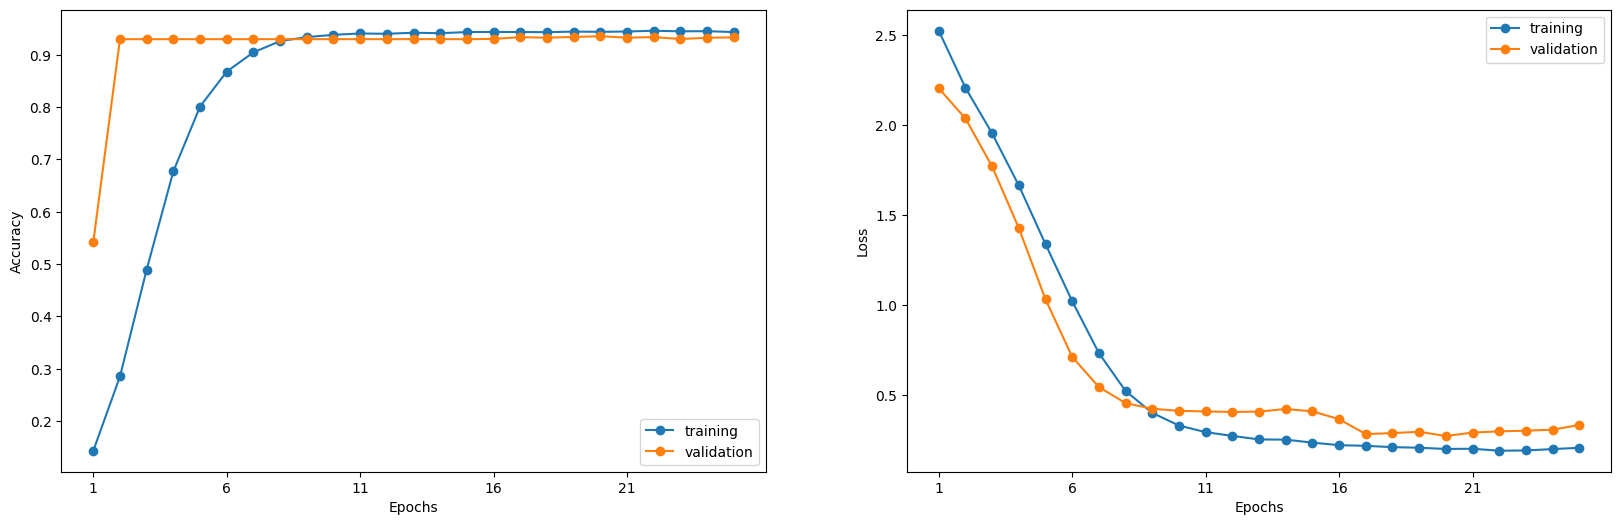

In [73]:
epochs = range(1, 26)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs[::5])
plt.ylabel("Loss")
plt.legend()
plt.show()

In [74]:
train_loss, train_acc = RNN_wordlevel.evaluate(X_train,  y_train, verbose=2)
val_loss, val_acc = RNN_wordlevel.evaluate(X_validation,  y_validation, verbose=2)
print('\nTrain accuracy:', train_acc)
print('\nVal accuracy:', val_acc)

1057/1057 - 2s - loss: 0.1777 - accuracy: 0.9468 - 2s/epoch - 2ms/step
118/118 - 0s - loss: 0.3350 - accuracy: 0.9332 - 198ms/epoch - 2ms/step

Train accuracy: 0.9468311667442322

Val accuracy: 0.9331735968589783


In [48]:
df_train['text'][0]

'I charge it at night and skip taking the cord with me because of the good battery life.'

In [101]:
input_phrase = ['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the'] # good battery life.'

# process for the model
processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]


# extract last 5 words
network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
network_input = network_input.reshape((1, SEQUENCE_LENGTH)) # shape: 1 x 5

# the RNN gives the probability of each word as the next one
predict_proba = RNN_wordlevel.predict(network_input, verbose=0)[0] # shape (4855,)
predict_label = number_to_tag[np.argmax(predict_proba)]
# # sample one word using these chances
# predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

# # add new index at the end of our list
# processed_phrase.append(predicted_index)

# # progress indicator
# print(i, end="\r")

# indices mapped to words - the method expects a list of lists so we need the extra bracket
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)
print(predict_label)

i charge it at night and skip taking the cord with me because of the
O


In [98]:
# def plot_image(i, predictions_array, true_label, img):
#   # true_label, img = true_label[i], img[i]
#   # plt.grid(False)
#   # plt.xticks([])
#   # plt.yticks([])

#   # plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(number_to_tag[predicted_label],
#                                 100*np.max(predictions_array),
#                                 number_to_tag[true_label]),
#                                 color=color)



In [102]:
# Evaluate the model's performance on the test data
score = RNN_wordlevel.evaluate(X_validation, y_validation, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

118/118 [==============================] - 0s 2ms/step - loss: 0.3350 - accuracy: 0.9332
Test loss: 0.3349929749965668
Test accuracy: 0.9331735968589783
